# DỰ ĐOÁN GIÁ LAPTOP


## 1. Giới thiệu

* Ngày nay, cùng với sự phát triển của khoa học và công nghệ cũng như trong bối cảnh dịch COVID 19 kéo dài, laptop trở thành một công cụ hữu ích phục vụ nhu cầu từ việc học online, làm việc tại nhà cho đến việc giải trí càng khiến cho thị trường laptop ngày càng nóng lên. Việc lựa chọn một chiếc laptop sao cho phù hợp với nhu cầu và túi tiền không phải là điều dễ dàng đối với nhiều người. 
* Nắm bắt được nhu cầu cũng như tâm lý người dùng, nhóm tụi em đã ứng dụng những kiến thức đã học trong bộ môn Khoa học dữ liệu để xây dựng mô hình “Dự đoán giá laptop” trên tập dữ liệu được lấy từ các trang website bán laptop nổi tiếng như fptshop.com.vn, philong.com.vn, cellphones.com.vn.
* Giải pháp của nhóm là sẽ sử dụng các công cụ như Selenium để hỗ trợ cào dữ liệu, sau đó xây dựng các mô hình hồi quy tuyến tính nhằm dự đoán giá laptop kết hợp với các kĩ thuật xử lý dữ liệu trống, dữ liệu ngoại lệ.


## 2. Thu thập và mô tả dữ liệu

*   Cào dữ liệu từ các trang fptshop.com.vn, cellphones.com.vn, philong.com.vn
*   Gộp dữ liệu và làm sạch dữ liệu



### 2.1 Cào dữ liệu

Để cào dữ liệu laptop từ trang web kể trên, sẽ có **2 bước xử lí chính**:


1.   Duyệt qua tất cả trang sản phẩm ở trang danh sách sản phẩm để lấy tất cả đường link chi tiết sản phẩm
2.   Truy cập vào từng đường link đã thu thập ở bước 1, tiến hành phân tích trang sản phẩm chi tiết để lấy các dữ liệu cần thiết

Kết quả: 3 file csv chứa dữ liệu thô
  * philong.csv
  * cellphone.csv
  * fptshop.csv

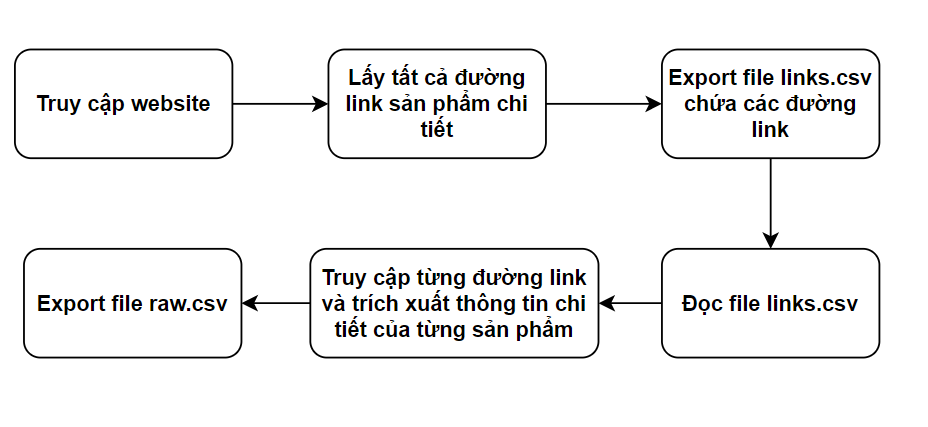

Class `CrawlData` chứa những phương thức cơ bản, dùng chung cho cả quá trình cào. \
Class `CrawlData` định nghĩa các phương thức: \
* _save_detail_link_file : Lưu tất cả các đường link chi tiết sản phẩm vào file
* _read_detail_link_file : Đọc tất cả các đường link chi tiết sản phẩm từ file 
* exec : Duyệt qua từng đường link chi tiết sản phẩm rồi tiến hành cào dữ liệu
* get_detail_links : Phương thức lấy đường link chi tiết của một trang
* get_info : Phương thức giúp lấy thông tin chi tiết của một trang


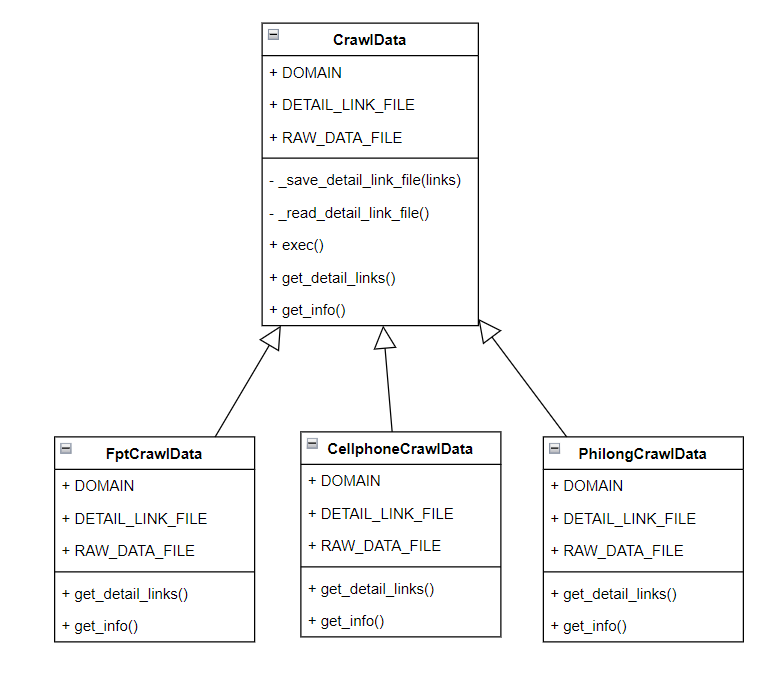

In [ ]:
from selenium import webdriver
import csv
import atexit
from Config import Config

class CrawlData:
    DOMAIN = ""
    DETAIL_LINK_FILE = ""
    RAW_DATA_FILE = ""
    driver = webdriver.Chrome(executable_path=Config["CHROME_DRIVER"])

    def _save_detail_link_file(self, link_details):
        with open(self.DETAIL_LINK_FILE, "w", encoding="utf-8") as f:
            for link in link_details:
                f.write(link + "\n")

    def _read_detail_link_file(self):
        link_details = None
        with open(self.DETAIL_LINK_FILE, "r") as f:
            link_details = f.readlines()
        return link_details
    
    def exec(self, ignore_get_detail_link=False):
        if ignore_get_detail_link == False:
            link_details = self.get_detail_links()
            self._save_detail_link_file(link_details)

        with open(self.RAW_DATA_FILE, "a", encoding="utf-8") as f:
            writer = csv.writer(f, delimiter=",", lineterminator='\n')
            header, header_set = [], set()

            @atexit.register 
            def printHeader(): 
                print(">>> ")
                print(header)
            
            link_details = self._read_detail_link_file()
            for link in link_details:
                try:
                    info = self.get_info(link)
                except Exception as e:
                    continue
                
                for key in info.keys():
                    if key not in header_set:
                        key = key.replace("\n", "")
                        header_set.add(key)
                        header.append(key)
                writer.writerow(info.get(col, '') for col in header)
            
            f.seek(0)
            f.writelines(",".join(header))

            print(",".join(header))
    
    def get_detail_links(self):
        '''
            Duyệt qua tất cả trang sản phẩm để lấy tất cả đường link chi tiết sản phẩm

            Output: List[string] Danh sách các đường link chi tiết sản phẩm
        '''
        pass

    def get_info(self, link):
        '''
            Phân tích trang sản phẩm chi tiết để lấy các dữ liệu cần thiết
            
            Input: URL chi tiết sản phẩm
            Output: Dict[str, str] chứa dữ liệu trích xuất từ HTML
        '''
        pass

Ví dụ về cào dữ liệu ở trang fptshop.com.vn

Tạo mới class `FptCrawlData` kế thừa từ `CrawlData` và override 2 phương thức `get_detail_links` và `get_info`

In [ ]:
from CrawlData import CrawlData
from time import sleep
from bs4 import BeautifulSoup
from selenium.webdriver.common.by import By
import requests
from Config import Config

class FptCrawlData(CrawlData):
    DOMAIN = Config["FPT"]["DOMAIN"]
    DETAIL_LINK_FILE = Config["FPT"]["DETAIL_LINK_FILE"]
    RAW_DATA_FILE = Config["FPT"]["RAW_DATA_FILE"]

    def get_detail_links(self):
        self.driver.get(self.DOMAIN + "/may-tinh-xach-tay")
        sleep(2)

        # click btn load more to show all available products
        load_more_btn = self.driver.find_element(By.CSS_SELECTOR, ".btn.btn-light")
        try:
            while load_more_btn is not None:
                load_more_btn.click()
                sleep(2)
                load_more_btn = self.driver.find_element(By.CSS_SELECTOR, ".btn.btn-light")
        except Exception:
            pass

        # get detail links
        soup = BeautifulSoup(self.driver.page_source, features="html.parser")
        link_details = []
        for a in soup.select(".cdt-product__info > h3 > a"):
            link_details.append(self.DOMAIN + a.get('href'))

        return link_details
    
    def get_info(self, link):
        self.driver.get(link)
        soup = BeautifulSoup(self.driver.page_source, features="html.parser")
        data = {}
        data['Title'] = soup.select_one('h1.st-name').get_text().strip().replace("\n", "") if soup.select_one('h1.st-name') else None
        data['Price sale'] = soup.select_one('.st-price__left .st-price-main').get_text() if soup.select_one('.st-price__left .st-price-main') else None
        data['Price origin'] = soup.select_one('.st-price__left .st-price-sub strike').get_text() if soup.select_one('.st-price__left .st-price-sub strike') else None

        for item in soup.select(".card.card-normal tr"):
            td = item.select("td")
            key = td[0].get_text()
            value = td[1].get_text()
            data[key] = value

        data['url'] = link.replace("\n", "")
        return data

if __name__ == "__main__":
    crawler = FptCrawlData()
    crawler.exec()

Source code chi tiết cào dữ liệu 3 trang fptshop, cellphone, philong ở thư mục `./crawl_data`

### 2.2 Gộp dữ liệu và làm sạch dữ liệu

1. Gộp Dữ liệu
  * Do dữ liệu cào từ 3 trang khác nhau, nên cần phải có một bước trung gian là gộp tất cả dữ liệu từ 3 trang thành 1 file dữ liệu duy nhất. 
  * Ở bước này, cần làm thủ công, xem thử dữ liệu của từng cột ở trang thứ nhất ứng với dữ liệu của cột nào ở trang thứ 2, trang thứ 3

2. Làm sạch dữ liệu \
Sau khi gộp dữ liệu, chúng ta đã có 1 file dữ liệu duy nhất, tuy nhiên dữ liệu lúc này chỉ là dữ liệu thô, cần phải tiến hành làm sạch dữ liệu như:
  * Chỉ trích xuất dữ liệu cần thiết (ví dụ như tên hãng laptop được trích xuất từ tên sản phẩm)
  * Tạo ra các cột dữ liệu mới
  * Định dạng và ép kiểu dữ liệu thích hợp

**Đầu vào**: 3 file csv chứa dữ liệu thô ở bước 2.1 \
**Kết quả**: 1 file dữ liệu đã được làm sạch (**clean_dataset.csv**)

#### 2.2.1 Gộp dữ liệu

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd "/content/gdrive/MyDrive/KHDL-CK-19N13-Team3/submit"

FPTSHOP_RAW = "./raw data/fptshop.csv"
CELLPHONE_RAW = "./raw data/cellphone.csv"
PHILONG_RAW = "./raw data/philong.csv"
EXPORT_FILE = "./clean data/test_clean_dataset_v1.csv"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/KHDL-CK-19N13-Team3/submit


Hàm lọc những cột dữ liệu trong DataFrame có số cột not null lớn hơn **percent**  phần trăm (mặc định là 80%)

In [ ]:
def filter_column_notnull(df, percent=0.8):
  filtered_column = []
  for column in df.columns:
    if (df[column].notnull().sum() > percent * df.shape[0]):
      filtered_column.append(column)
  return filtered_column

##### cellphone.csv

In [ ]:
dfCellphoneRaw = pd.read_csv(CELLPHONE_RAW)
dfCellphoneRaw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Title                  801 non-null    object
 1   Description            729 non-null    object
 2   Price sale             705 non-null    object
 3   Price origin           669 non-null    object
 4   Loại CPU               793 non-null    object
 5   Loại card đồ họa       784 non-null    object
 6   Dung lượng RAM         774 non-null    object
 7   Loại RAM               729 non-null    object
 8   Ổ cứng                 791 non-null    object
 9   Kích thước màn hình    791 non-null    object
 10  Độ phân giải màn hình  778 non-null    object
 11  Công nghệ màn hình     695 non-null    object
 12  Màn hình cảm ứng       679 non-null    object
 13  Chất liệu tấm nền      612 non-null    object
 14  Độ phân giải           752 non-null    object
 15  Cổng giao tiếp         

In [ ]:
filtered_column = filter_column_notnull(dfCellphoneRaw)
filtered_column

['Title',
 'Description',
 'Price sale',
 'Price origin',
 'Loại CPU',
 'Loại card đồ họa',
 'Dung lượng RAM',
 'Loại RAM',
 'Ổ cứng',
 'Kích thước màn hình',
 'Độ phân giải màn hình',
 'Công nghệ màn hình',
 'Màn hình cảm ứng',
 'Độ phân giải ',
 'Cổng giao tiếp',
 'Pin',
 'Hệ điều hành',
 'Wi-Fi',
 'Bluetooth',
 'Kích thước',
 'Trọng lượng',
 'Tính năng đặc biệt',
 'url']

Tiến hành loại bỏ những hàng dữ liệu có cột `Price Sale` là giá trị trống

In [ ]:
dfCellphoneRaw = dfCellphoneRaw[dfCellphoneRaw['Price sale'].notna()]
dfCellphoneRaw.shape

(705, 40)

> Làm tương tự vậy với 2 file dữ liệu còn lại

##### fptshop.csv

In [ ]:
dfFptRaw = pd.read_csv(FPTSHOP_RAW)
filtered_column = filter_column_notnull(dfFptRaw)
filtered_column

['Title',
 'Price sale',
 'Price origin',
 'Kích thước',
 'Trọng lượng sản phẩm',
 'Chất liệu',
 'Hãng CPU',
 'Công nghệ CPU',
 'Loại CPU',
 'Tốc độ CPU',
 'Tốc độ tối đa',
 'Số nhân',
 'Số luồng',
 'Bộ nhớ đệm',
 'Dung lượng RAM',
 'Loại RAM',
 'Tốc độ RAM',
 'Số khe cắm rời',
 'Số khe RAM còn lại',
 'Số RAM onboard',
 'Kích thước màn hình',
 'Công nghệ màn hình',
 'Độ phân giải',
 'Loại màn hình',
 'Tần số quét',
 'Tấm nền',
 'Màn hình cảm ứng',
 'Hãng',
 'Model',
 'Kiểu ổ cứng',
 'Tổng số khe cắm SSD/HDD',
 'Số khe SSD/HDD còn lại',
 'Loại SSD',
 'Dung lượng',
 'Cổng giao tiếp',
 'Wifi',
 'Bluetooth',
 'Webcam',
 'Số lượng loa',
 'Kiểu bàn phím',
 'Loại PIN',
 'Dung lượng pin',
 'OS',
 'Version',
 'Type',
 'url']

In [ ]:
dfFptRaw = dfFptRaw[dfFptRaw['Price sale'].notna()]
dfFptRaw.shape

(237, 71)

##### philong.csv

In [ ]:
dfPhilongRaw = pd.read_csv(PHILONG_RAW)
filtered_column = filter_column_notnull(dfPhilongRaw, 0.3)
filtered_column

['Title',
 'Price sale',
 'Price origin',
 'hãng sản xuất',
 'tên sản phẩm',
 'bộ nhớ đệm',
 'ram',
 'số khe cắm',
 'dung lượng',
 'tốc độ vòng quay',
 'khe cắm ssd mở rộng',
 'ổ đĩa quang (odd)',
 'độ phân giải',
 'card màn hình',
 'wireless',
 'lan',
 'bluetooth',
 'kiểu bàn phím',
 'chuột',
 'kết nối usb',
 'kết nối hdmi/vga',
 'tai nghe',
 'camera',
 'card mở rộng',
 'loa',
 'kiểu pin',
 'sạc pin',
 'hệ điều hành\xa0(bản quyền) đi kèm',
 'kích thước (dài x rộng x cao)',
 'trọng lượng',
 'màu sắc',
 'url',
 'hệ điều hành',
 'màn hình',
 'webcam',
 'pin',
 'bộ vi xử lý',
 'tốc độ']

In [ ]:
dfPhilongRaw = dfPhilongRaw[dfPhilongRaw['Price sale'].notna()]
dfPhilongRaw.shape

(348, 269)

**Gộp dữ liệu**

Dựa vào filtered_column ở cả 3 file, tiến hành tìm các cột có dữ liệu tương đồng và đổi tên sao cho những cột đó có tên giống nhau (những cột có tên giống nhau mới gộp được)

| cellphone.csv  | philong.csv    | fptshop.csv  |
|----------------|----------------|--------------|
| Dung lượng RAM | Dung lượng RAM | ram          |
| Hệ điều hành   | OS             | hệ điều hành |
| ...            | ...            | ...          |

In [ ]:
dfPhilongRaw.rename(columns={'ram': 'Dung lượng RAM', 'màn hình': 'Kích thước màn hình', 'bộ vi xử lý': 'Loại CPU', 
                             'kiểu pin': 'Pin', 'bluetooth': 'Bluetooth', 'trọng lượng': 'Trọng lượng', 
                             'hệ điều hành': 'Hệ điều hành', 'dung lượng': 'Ổ cứng'}, inplace=True)
dfPhilongRaw['Độ phân giải màn hình'] = dfPhilongRaw['Kích thước màn hình']

In [ ]:
dfFptRaw.rename(columns={'Độ phân giải': 'Độ phân giải màn hình', 'Dung lượng pin': 'Pin', 'Trọng lượng sản phẩm': 'Trọng lượng', 
                         'OS': 'Hệ điều hành', 'Dung lượng': 'Ổ cứng'}, inplace=True)

In [ ]:
dfPhilongRaw = dfPhilongRaw[dfPhilongRaw["Dung lượng RAM"].notnull()]

In [ ]:
dfMerged = dfCellphoneRaw.append([dfFptRaw, dfPhilongRaw])
dfMerged = dfMerged[dfMerged["Price sale"].notnull()]
dfMerged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1049 entries, 0 to 347
Columns: 345 entries, Title to kích thước (w x d x h)
dtypes: float64(12), object(333)
memory usage: 2.8+ MB


#### 2.2.2 Làm sạch dữ liệu

**ProductName** : Tên sản phẩm

Đổi tên cột dữ liệu

In [ ]:
df = pd.DataFrame()
df["ProductName"] = dfMerged["Title"].copy()

**PriceSale** : Giá bán

* Dùng Regex `/\d+/` để lấy những chữ số trong cột
* Ép sang kiểu số

In [ ]:
series = dfMerged["Price sale"].copy()
for i in range(len(series)):
  if isinstance(series.iloc[i], str):
    numbers = re.findall(r"\d+", series.iloc[i])
    if len(numbers) > 0:
      series.iloc[i] = int("".join(numbers))
    else:
      series.iloc[i] = None
  else:
    series.iloc[i] = None
df["PriceSale"] = series

In [ ]:
df["PriceSale"]

0      18690000
1      18290000
2      16390000
3      13490000
4       9990000
         ...   
262    16990000
263    23290000
314        None
316        None
347        None
Name: PriceSale, Length: 1049, dtype: object

**Brand** : Thương hiệu laptop

* Trích xuất thương hiệu laptop từ tên sản phẩm
* Ví dụ: Laptop có tên `Laptop Acer Gaming Aspire 7 A715-42G-R05G (NH....` ==> Hãng ACER

In [ ]:
series = dfMerged["Title"].copy()
for i in range(len(series)):
  if isinstance(series.iloc[i], str):
    brands = re.findall("(?i)Acer|Asus|Apple|Macbook|HP|Lenevo|NUC|LG|Huawei|Lenovo|MSI|Dell|Vostro|Microsoft|Surface|Gigabyte|Fujitsu|Chuwi|Avita|Masstel", series.iloc[i])
    if len(brands) > 0:
      brand = brands[0].lower()
      if brand in ["apple", "macbook"]:
        series.iloc[i] = "APPLE"
      elif brand in ["microsoft", "surface"]:
        series.iloc[i] = "MICROSOFT"
      elif brand == "nuc":
        series.iloc[i] = "INTEL"
      elif brand in ["dell", "vostro"]:
        series.iloc[i] = "DELL"
      else:
        series.iloc[i] = brand.upper()
df["Brand"] = series

In [ ]:
df["Brand"].unique()

array(['ACER', 'LENOVO', 'ASUS', 'DELL', 'HP', 'APPLE', 'MSI', 'HUAWEI',
       'MICROSOFT', 'LG', 'FUJITSU', 'INTEL', 'GIGABYTE', 'LENEVO',
       'AVITA', 'CHUWI', 'MASSTEL'], dtype=object)

**RamCapacity** : Dung lượng RAM

* Dùng Regex `\d+(?=\s*GB)` để lấy những số đứng trước chữ `GB`
* Ép sang kiểu dữ liệu số nguyên

In [ ]:
series = dfMerged["Dung lượng RAM"].copy()
for i in range(len(series)):
  if series.iloc[i] is not None and isinstance(series.iloc[i], str):
    numbers = re.findall(r"(?i)\d+(?=\s*GB)", series.iloc[i])
    if len(numbers) > 0:
      series.iloc[i] = int(numbers[0])
    else:
      series.iloc[i] = None
  else:
    series.iloc[i] = None
df["RamCapacity"] = series

In [ ]:
df["RamCapacity"].unique()

array([8, 16, 4, 32, 64, 12, None], dtype=object)

**DisplayResolution** : Độ phân giải màn hình

* Dùng Regex để trích xuất `1920 x 1080 pixels (FullHD)` ==> `1920 x 1080`

In [ ]:
series = dfMerged["Độ phân giải màn hình"].copy()
for i in range(len(series)):
  if series.iloc[i] is not None and isinstance(series.iloc[i], str):
    numbers = re.findall(r"(?i)\d+\s*x\s*\d+", series.iloc[i])
    if len(numbers) > 0:
      series.iloc[i] = numbers[0].replace(" ", "")
    else:
      series.iloc[i] = None
  else:
    series.iloc[i] = None
df["DisplayResolution"] = series

In [ ]:
df["DisplayResolution"].unique()

array(['1920x1080', '2880x1800', '1080x1920', None, '1366x768',
       '2560x1600', '5120x2880', '3024x1964', '2160x1440', '2736x1824',
       '2560x1440', '1920x1200', '1536x1024', '2880x1920', '4480x2520',
       '3456x2234', '2256x1504', '3840x2160', '2160x1350', '4096x2304',
       '2560x1080', '2240x1400', '1280x720', '1920x1280', '1200x1920'],
      dtype=object)

**DisplaySize** : Kích thước màn hình

In [ ]:
series = dfMerged["Kích thước màn hình"].copy()
for i in range(len(series)):
  if series.iloc[i] is not None and isinstance(series.iloc[i], str):
    numbers = re.findall(r"(?i)\d+\.*\d+(?=\s*inch)", series.iloc[i])
    if len(numbers) > 0:
      series.iloc[i] = float(numbers[0])
    else:
      series.iloc[i] = None
  else:
    series.iloc[i] = None
df["DisplaySize"] = series

In [ ]:
df["DisplaySize"]

0      15.6
1      14.0
2      15.6
3      14.0
4      15.6
       ... 
262    None
263    None
314    None
316    15.6
347    None
Name: DisplaySize, Length: 1049, dtype: object

**CPU**

In [ ]:
series = dfMerged["Loại CPU"].copy()
for i in range(len(series)):
  if series.iloc[i] is not None and isinstance(series.iloc[i], str):
    s = re.findall(r"(?i)(AMD|Ryzen|Apple|M1|Intel|i3|i5|i7|i9|i10|i11|\s\d+(G|H|U|P)|N\d+)", series.iloc[i])
    if len(s) > 0:
      s = s[0][0].replace(" ", "").lower()
      if s == "amd" or s == "ryzen":
        series.iloc[i] = "AMD"
      elif s == "apple" or s == "m1":
        series.iloc[i] = "APPLE"
      else:
        series.iloc[i] = "INTEL"
    else:
      series.iloc[i] = None
  else:
    series.iloc[i] = None
df["CPUBrand"] = series

In [ ]:
df["CPUBrand"].unique()

array(['AMD', 'INTEL', None, 'APPLE'], dtype=object)

**PinCapacity** : Dung lượng pin (Wh)

In [ ]:
capacitySeries = dfMerged["Pin"].copy()
cellSeries = dfMerged["Pin"].copy()

for i in range(len(capacitySeries)):
  if capacitySeries.iloc[i] is not None and isinstance(capacitySeries.iloc[i], str):
    s = re.findall(r"(?i)\d+\s*\.*\d*(?=Wh)", capacitySeries.iloc[i])
    if len(s) > 0:
      capacitySeries.iloc[i] = float(s[0])
    else:
      capacitySeries.iloc[i] = None
  else:
    capacitySeries.iloc[i] = None
df["PinCapacity"] = capacitySeries

In [ ]:
df["PinCapacity"]

0      None
1      56.5
2      48.0
3      None
4      None
       ... 
262    48.0
263    67.0
314    None
316    None
347    None
Name: PinCapacity, Length: 1049, dtype: object

**PinCell** : Số cell của pin laptop

In [ ]:
for i in range(len(capacitySeries)):
  if cellSeries.iloc[i] is not None and isinstance(cellSeries.iloc[i], str):
    cells  = re.findall(r"(?i)\d+(?=\s*\-*cell)", cellSeries.iloc[i])
    if len(cells) > 0:
      cellSeries.iloc[i] = int(cells[0])
    else:
      cellSeries.iloc[i] = None
  else:
    cellSeries.iloc[i] = None
df["PinCell"] = cellSeries

In [ ]:
df["PinCell"].unique()

array([4, None, 3, 2, 6], dtype=object)

**Bluetooth**

In [ ]:
series = dfMerged["Bluetooth"].copy()
for i in range(len(series)):
  if series.iloc[i] is not None and isinstance(series.iloc[i], str):
    s = re.findall(r"(?i)\d(?=\.\d)", series.iloc[i])
    if len(s) > 0:
      series.iloc[i] = int(s[0])
    else:
      series.iloc[i] = None
  else:
    series.iloc[i] = None
df["Bluetooth"] = series

In [ ]:
df["Bluetooth"].unique()

array([5, None, 4, 6], dtype=object)

**Weight** : Trọng lượng của laptop (Kg)

In [ ]:
series = dfMerged["Trọng lượng"].copy()
for i in range(len(series)):
  if series.iloc[i] is not None and isinstance(series.iloc[i], str):
    s = re.findall(r"(?i)\d+\.*\d+(?=\s*kg)", series.iloc[i])
    if len(s) > 0:
      series.iloc[i] = float(s[0])
    else:
      series.iloc[i] = None
  else:
    series.iloc[i] = None
df["Weight"] = series

In [ ]:
df["Weight"]

0       2.2
1      1.38
2       2.3
3      1.73
4      None
       ... 
262     2.1
263     1.3
314    None
316     2.2
347    None
Name: Weight, Length: 1049, dtype: object

**OS** : Hệ điều hành

In [ ]:
series = dfMerged["Hệ điều hành"].copy()
for i in range(len(series)):
  if series.iloc[i] is not None and isinstance(series.iloc[i], str):
    s = re.findall(r"(?i)window|macos|free", series.iloc[i])
    if len(s) > 0:
      series.iloc[i] = s[0].upper()
    else:
      series.iloc[i] = None
  else:
    series.iloc[i] = None
df["OS"] = series

In [ ]:
df["OS"]

0      WINDOW
1      WINDOW
2      WINDOW
3        FREE
4      WINDOW
        ...  
262      None
263      None
314    WINDOW
316    WINDOW
347    WINDOW
Name: OS, Length: 1049, dtype: object

**DiskSpace** : Dung lượng ổ cứng (GB)

In [ ]:
series = dfMerged["Ổ cứng"].copy()
for i in range(len(series)):
  if series.iloc[i] is not None and isinstance(series.iloc[i], str):
    s = re.findall(r"(?i)\d+(?=\s*GB)", series.iloc[i])
    s2 = re.findall(r"(?i)\d+(?=\s*TB)", series.iloc[i])
    if len(s) > 0:
      series.iloc[i] = int(s[0])
    elif len(s2) > 0:
      series.iloc[i] = 1024*int(s2[0])
    else:
      series.iloc[i] = None
  else:
    series.iloc[i] = None
df["DiskSpace"] = series

In [ ]:
df["DiskSpace"]

0       512
1       512
2       512
3      1024
4       128
       ... 
262     512
263     512
314    None
316    None
347    None
Name: DiskSpace, Length: 1049, dtype: object

**Sau khi clean data, nhóm có được dataset gồm 13 feature, 1049 sample**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1049 entries, 0 to 347
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ProductName        1049 non-null   object
 1   PriceSale          1037 non-null   object
 2   Brand              1049 non-null   object
 3   RamCapacity        1029 non-null   object
 4   DisplayResolution  964 non-null    object
 5   DisplaySize        948 non-null    object
 6   CPUBrand           706 non-null    object
 7   PinCapacity        668 non-null    object
 8   PinCell            788 non-null    object
 9   Bluetooth          983 non-null    object
 10  Weight             964 non-null    object
 11  OS                 932 non-null    object
 12  DiskSpace          989 non-null    object
dtypes: object(13)
memory usage: 114.7+ KB


| STT |     Đặc trưng     |            Mô tả           | Kiểu dữ liệu | Số mẫu dữ liệu trống |
|:---:|:-----------------:|:--------------------------:|:------------:|:--------------------:|
|  1  | ProductName       | Tên laptop                 | String       |           0          |
|  2  | PriceSale         | Giá bán (vnđ)              | Integer      |          12          |
|  3  | Brand             | Thương hiệu laptop         | String       |           0          |
|  4  | RamCapacity       | Dung lượng RAM (GB)        | Integer      |          20          |
|  5  | DisplayResolution | Độ phân giải màn hình      | String       |          85          |
|  6  | DisplaySize       | Kích thước màn hình (inch) | Float        |          101         |
|  7  | CPUBrand          | Thương hiệu chip           | String       |          132         |
|  8  | PinCapacity       | Dung lượng pin (Wh)        | Float        |          381         |
|  9  | PinCell           | Số lượng cell pin (cell)   | Integer      |          261         |
|  10 | Bluetooth         | Phiên bản Bluetooth        | Integer      |          66          |
|  11 | Weight            | Khối lượng laptop (Kg)     | Float        |          85          |
|  12 | OS                | Hệ điều hành               | String       |          117         |
|  13 | DiskSpace         | Dung lượng ổ cứng          | Integer      |          60          |

In [ ]:
df.head(5)

,ProductName,PriceSale,Brand,RamCapacity,DisplayResolution,DisplaySize,CPUBrand,PinCapacity,PinCell,Bluetooth,Weight,OS,DiskSpace
0,Laptop Gaming Acer Nitro 5 AN515 45 R6EV,18690000,ACER,8,1920x1080,15.6,AMD,None,4,5,2.2,WINDOW,512
1,Laptop Lenovo Ideapad 5 PRO 14ACN6 82L700M9VN,18290000,LENOVO,16,2880x1800,14.0,AMD,56.5,None,5,1.38,WINDOW,512
2,Laptop Asus Gaming TUF FX506LH HN188W,16390000,ASUS,8,1920x1080,15.6,INTEL,48.0,3,5,2.3,WINDOW,512
3,Laptop Lenovo ThinkPad E14,13490000,LENOVO,8,1080x1920,14.0,INTEL,None,3,5,1.73,FREE,1024
4,Laptop Dell Inspiron 3511 5G8TF,9990000,DELL,4,None,15.6,INTEL,None,None,None,None,WINDOW,128


**Export** dữ liệu

In [ ]:
df.to_csv(EXPORT_FILE)

### 2.3 Trực quan hoá một số đặc trưng

In [ ]:
print(f"Tổng số lượng mẫu: {df.shape[0]}")

Tổng số lượng mẫu: 1049


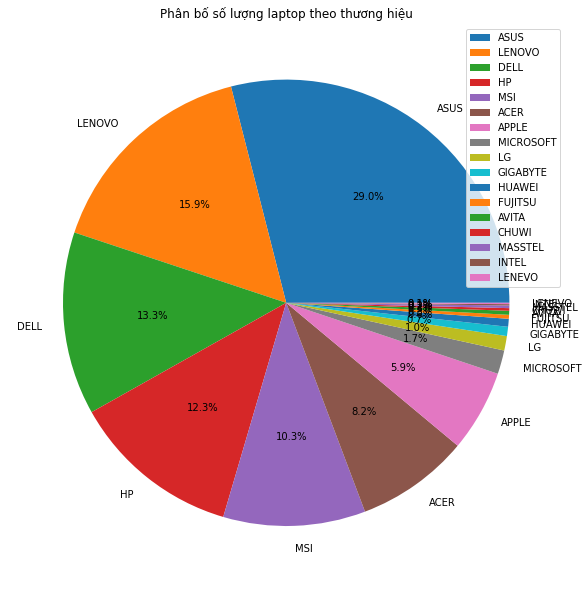

In [ ]:
plt.figure(figsize=(10,15))
brands = df["Brand"].value_counts().sort_values(ascending=False)
plt.pie(brands.values, labels=brands.keys(), autopct='%1.1f%%')
plt.title("Phân bố số lượng laptop theo thương hiệu")
plt.legend(labels=brands.keys())
plt.show()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  exec(code_obj, self.user_global_ns, self.user_ns)


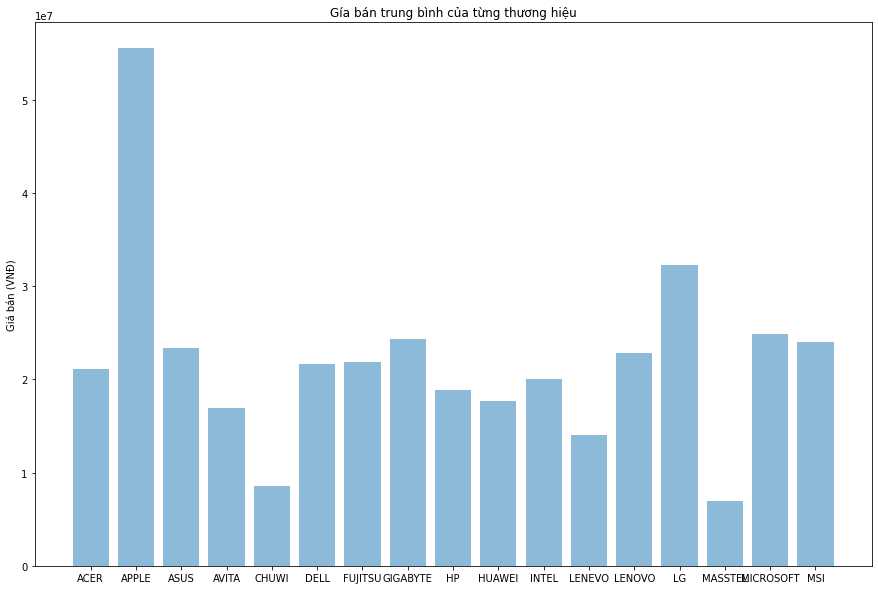

In [ ]:
price_brand = df.groupby("Brand").mean()["PriceSale"]
price_brand.index
plt.figure(figsize=(15,10))
plt.bar(price_brand.index, price_brand, align='center', alpha=0.5)

plt.ylabel('Giá bán (VNĐ)')
plt.title('Gía bán trung bình của từng thương hiệu')

plt.show()

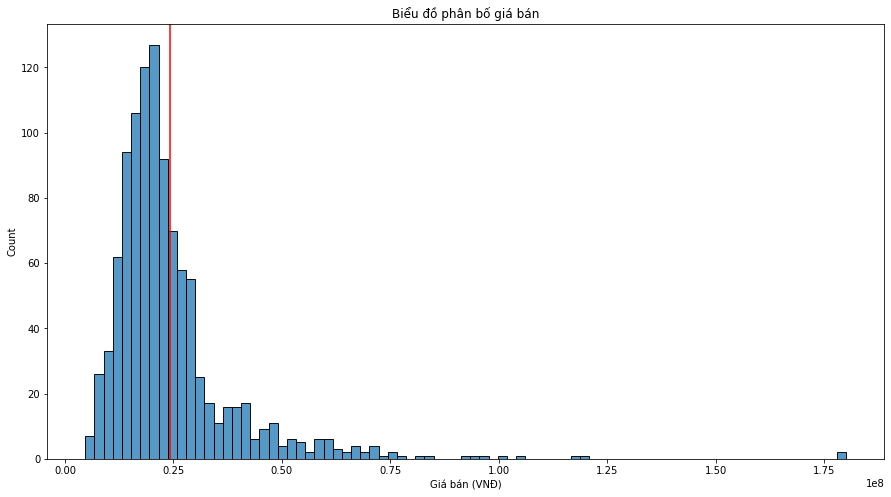

In [ ]:
price_sale = df["PriceSale"].dropna()
price_mean = price_sale.mean()
plt.figure(figsize=(15,8))
sns.histplot(data=price_sale)
plt.axvline(price_mean, color='r')
plt.xlabel('Giá bán (VNĐ)')
plt.title("Biểu đồ phân bố giá bán")
plt.show()

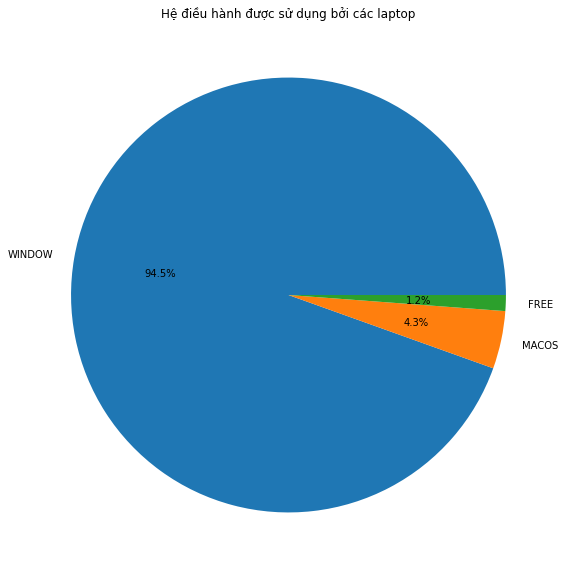

In [ ]:
plt.figure(figsize=(10,10))
os = df["OS"].value_counts().sort_values(ascending=False)
plt.pie(os.values, labels=os.keys(), autopct='%1.1f%%')
plt.title("Hệ điều hành được sử dụng bởi các laptop")
plt.show()

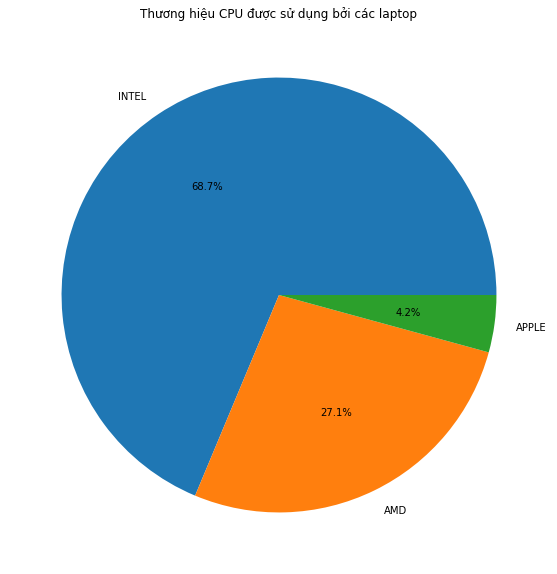

In [ ]:
plt.figure(figsize=(10,10))
cpu = df["CPUBrand"].value_counts().sort_values(ascending=False)
plt.pie(cpu.values, labels=cpu.keys(), autopct='%1.1f%%')
plt.title("Thương hiệu CPU được sử dụng bởi các laptop")
plt.show()

## 3. Trích xuất đặc trưng

In [ ]:
!pip install eli5

In [ ]:
import pandas as pd
import random
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings("ignore")
from google.colab import drive


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Hàm này được sử dụng trong phần 3 để kiếm tra hiệu suất của mô hình

In [ ]:
def test_model(X_train, X_test, y_train, y_test):
  model = LinearRegression()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  return mean_absolute_percentage_error(y_test, y_pred)

## Load dataset

In [ ]:
DATASET = r"/content/drive/MyDrive/Colab Notebooks/KHDL-CK-19N13-Team3/crawl/clean_dataset_v3.csv"
dataset = pd.read_csv(DATASET)
dataset = dataset[["ProductName",	"PriceSale",	"Brand",	"RamCapacity",	"DisplaySize",	"CPUBrand",	"PinCapacity",	"PinCell",	"Bluetooth",	"Weight",	"OS",	"DiskSpace"]]
dataset

,ProductName,PriceSale,Brand,RamCapacity,DisplaySize,CPUBrand,PinCapacity,PinCell,Bluetooth,Weight,OS,DiskSpace
0,Laptop Gaming Acer Nitro 5 AN515 45 R6EV,18690000.0,ACER,8.0,15.6,INTEL,NaN,4.0,5.0,2.20,WINDOW,512.0
1,Laptop Lenovo Ideapad 5 PRO 14ACN6 82L700M9VN,18290000.0,LENOVO,16.0,14.0,INTEL,56.5,NaN,5.0,1.38,WINDOW,512.0
2,Laptop Asus Gaming TUF FX506LH HN188W,16390000.0,ASUS,8.0,15.6,INTEL,48.0,3.0,5.0,2.30,WINDOW,512.0
3,Laptop Lenovo ThinkPad E14,13490000.0,LENOVO,8.0,14.0,INTEL,NaN,3.0,5.0,1.73,FREE,1024.0
4,Laptop Dell Inspiron 3511 5G8TF,9990000.0,DELL,4.0,15.6,INTEL,NaN,NaN,NaN,NaN,WINDOW,128.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1044,Laptop Acer Gaming Aspire 7 A715-42G-R05G (NH....,16990000.0,ACER,8.0,NaN,NaN,48.0,3.0,5.0,2.10,NaN,512.0
1045,Laptop Asus ZenBook Flip 13 Evo UX363EA-HP726W...,23290000.0,ASUS,8.0,NaN,NaN,67.0,4.0,5.0,1.30,NaN,512.0
1046,Laptop Acer Swift 3 Evo SF314 511 59LV (i5-113...,NaN,ACER,16.0,NaN,NaN,NaN,NaN,5.0,NaN,WINDOW,NaN
1047,"LAPTOP ACER NITRO 5 AN515-57-720A (i7-11800H,8...",NaN,ACER,8.0,15.6,NaN,NaN,NaN,5.0,2.20,WINDOW,NaN


## Làm sạch dữ liệu

In [ ]:
# Xoa mau co du lieu gia tien bi trong
dataset = dataset.dropna(subset=["PriceSale"])
# Xoa mau co hon 1 trưong trong
dataset["num_nan"] = dataset.isnull().apply(lambda row: row.sum(), axis=1)
dataset = dataset[dataset.num_nan <= 1]

## Xử lý dữ liệu trống với dữ liệu category

In [ ]:
dataset = dataset.reset_index()

dataset["CPUBrand"].fillna(random.choice(dataset[dataset["CPUBrand"] != np.nan]["CPUBrand"]))
dataset["OS"].fillna(random.choice(dataset[dataset["OS"] != np.nan]["OS"]))
dataset = dataset[["ProductName",	"PriceSale",	"Brand",	"RamCapacity",	"DisplaySize",	"CPUBrand",	"PinCapacity",	"PinCell",	"Bluetooth",	"Weight",	"OS",	"DiskSpace"]]

## Mã hóa dữ liệu

### Dữ liệu số

In [ ]:
number_column = ["RamCapacity",	"DisplaySize", "PinCapacity",	"PinCell",	"Bluetooth",	"Weight",	"DiskSpace"]
number_feature = dataset[number_column]
X_number = number_feature.to_numpy()
print(X_number.shape)

(796, 7)


In [ ]:
y = dataset["PriceSale"].to_numpy()
print(y.shape)

(796,)


### Dữ liệu category

In [ ]:
category_column = ["Brand",	"CPUBrand",	"OS"]
category_feature = dataset[category_column]
X_category = category_feature.to_numpy()

encode = OneHotEncoder()
X_category = encode.fit_transform(X_category)
print(X_category.shape)

(796, 20)


## Xử lý dữ liệu trống sử dụng Iterative Imputer
- Iterative Imputer là phương pháp lấp đầy dữ liệu trống bằng cách xem cột dữ liệu trống là y, các cột còn lại là X, đào tạo một mô hình hồi quy để dữ đoán fúa trị tại vị trí trống đó 

In [ ]:
impute_it = IterativeImputer()
X_number = impute_it.fit_transform(X_number)
X_number.shape

(796, 7)

## Mối tương quan giữa các thuộc tính số
- Các dữ liệu đều có mối tương quan với trhuộc tính giá tiền
- Trường Weight có tương quan rất thấp, cần loại bỏ trường này

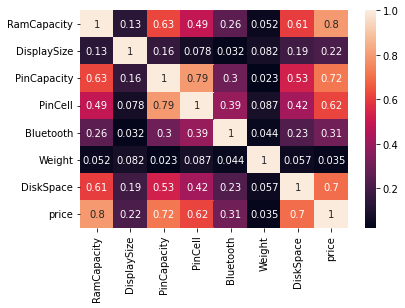

In [ ]:
df = pd.DataFrame({number_column[i]: X_number[:, i] for i in range(X_number.shape[1])})
df["price"] = y
ax = sns.heatmap(df.corr(), annot=True)

## Phân chia giữ liệu train và test

In [ ]:
X = np.concatenate([X_number, X_category.toarray()], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

error = test_model(X_train, X_test, y_train, y_test)
print(f"First error: {error}")

First error: 0.18047543137171415


## Kết quả sau khi loại bỏ trường Weight
- MAPE cải thiện từ 18.04% -> 17.97%

In [ ]:
X_number = X_number[:, [0, 1, 2, 3, 4, 6]]
X = np.concatenate([X_number, X_category.toarray()], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

error = test_model(X_train, X_test, y_train, y_test)
print(f"Error after remove Weight: {error}")

Error after remove Weight: 0.1796580690326967


## Xử lý ngoại lệ

### Phân bố của các thuộc tính 
=> Các trường đều có phân bố tương đối xấp xỉ phân bố chuẩn

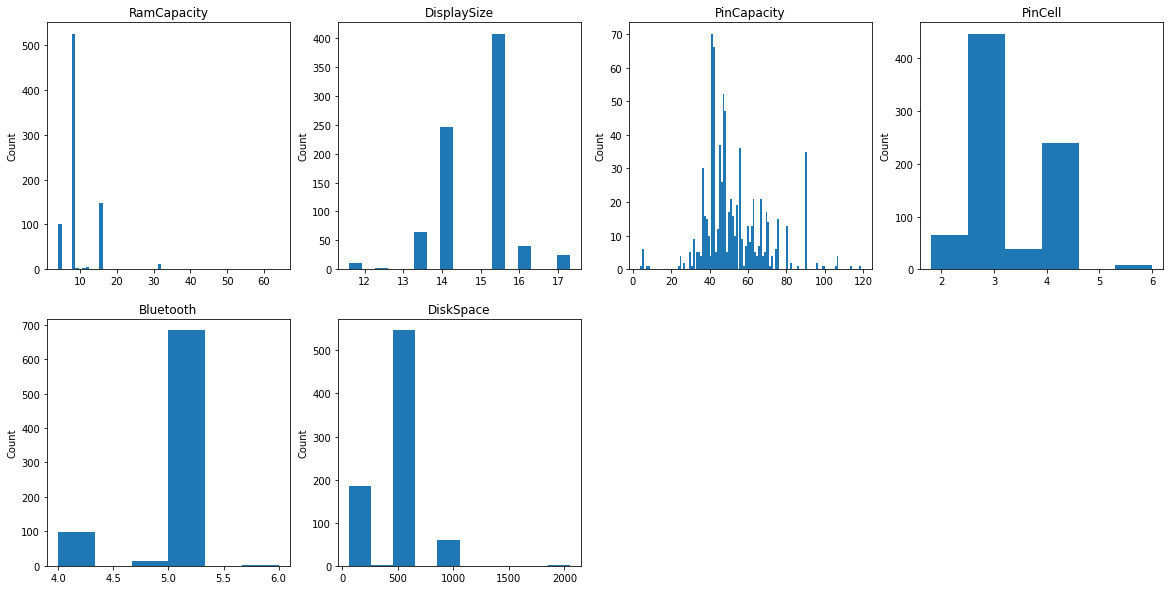

In [ ]:
number_column = ["RamCapacity",	"DisplaySize", "PinCapacity",	"PinCell",	"Bluetooth",	"DiskSpace"]
plt.figure(0, (20, 10))
for i in range(len(number_column)):
  if i == len(number_column) - 1:
    plt.subplot(2, 4, i+1).hist(X_number[:, i])
  else:
    plt.subplot(2, 4, i+1).hist(X_number[:, i], bins=int(X_number[:, i].max()))
  plt.subplot(2, 4, i+1).set_ylabel("Count")
  plt.subplot(2, 4, i+1).set_title(number_column[i])

### Boxplot của các thuộc tính
=> Tất cả các thuộc tính đều cần được xử lý ngoại lệ

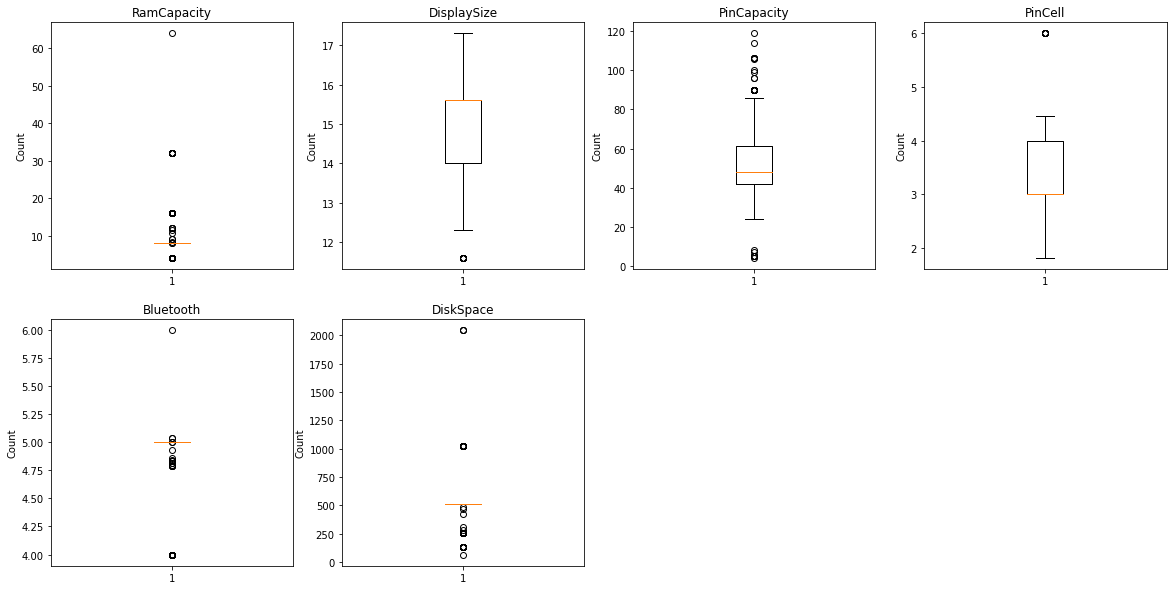

In [ ]:
number_column = ["RamCapacity",	"DisplaySize", "PinCapacity",	"PinCell",	"Bluetooth",	"DiskSpace"]
plt.figure(0, (20, 10))
for i in range(len(number_column)):
  plt.subplot(2, 4, i+1).boxplot(X_number[:, i])
  plt.subplot(2, 4, i+1).set_ylabel("Count")
  plt.subplot(2, 4, i+1).set_title(number_column[i])

### Xử lý dữ liệu ngoại lệ
- Tìm giá trị trên tập train để xử lí ngoại lệ
- Kết quả cài thiện từ 17.96% -> 17.92%

In [ ]:
def outlier_process(X_train, X_test, nomalized_field: list=[], skewed_field: list=[]):
  for i in nomalized_field:
    uppper_boundary = X_train[:, i].mean() + 3 * X_train[:, i].std()
    lower_boundary = X_train[:, i].mean() - 3 * X_train[:, i].std()
    X_train[X_train[:, i] < lower_boundary, i] = lower_boundary
    X_train[X_train[:, i] > uppper_boundary, i] = uppper_boundary
    X_test[X_test[:, i] < lower_boundary, i] = lower_boundary
    X_test[X_test[:, i] > uppper_boundary, i] = uppper_boundary

  for i in skewed_field:
    IQR = np.quantile(X_train[:, i], 0.75) - np.quantile(X_train[:, i], 0.25)
    uppper_boundary = np.quantile(X_train[:, i], 0.25)-(IQR*1.5)
    lower_boundary = np.quantile(X_train[:, i], 0.75)+(IQR*1.5)
    X_train[X_train[:, i] < lower_boundary, i] = lower_boundary
    X_train[X_train[:, i] > uppper_boundary, i] = uppper_boundary
    X_test[X_test[:, i] < lower_boundary, i] = lower_boundary
    X_test[X_test[:, i] > uppper_boundary, i] = uppper_boundary
  return X_train, X_test

X_train, X_test = outlier_process(X_train, X_test, [0, 1, 2, 3, 4, 5])

In [ ]:
error = test_model(X_train, X_test, y_train, y_test)
print(f"Error after outlier process: {error}")

Error after outlier process: 0.17923263822568455


## Chuẩn hóa dữ liệu
- Chỉ chuẩn hóa với dư liệu số
- Chuẩn hóa theo công thức z = (x - mean) / std
- Thường dùng cho các dữ liệu có đơn vị khác nhau
- Fit trên tập train và Transform trên tập train và tập test

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train[:, :6])

X_train[:, :6] = scaler.transform(X_train[:, :6])
X_test[:, :6] = scaler.transform(X_test[:, :6])

In [ ]:
error = test_model(X_train, X_test, y_train, y_test)
print(f"Error after nomalize process: {error}")

Error after nomalize process: 0.17923263822568566


## Lựa chọn thuộc tính
- Phương pháp Permutation Importance
- Ý tưởng là loại bỏ các thuộc tính rồi huấn luyện để xem tầm quan trọng của thuộc tính đó

### Tính mức độ quan trọng của các thuộc tính

In [ ]:
model = LinearRegression()
perm = PermutationImportance(model, scoring="neg_mean_absolute_percentage_error", cv=5, n_iter=1, random_state=69).fit(X_train, y_train)
eli5.show_weights(perm)

Weight,Feature
0.1075 ± 0.0156,x0
0.0506 ± 0.0205,x5
0.0324 ± 0.0270,x2
0.0117 ± 0.0086,x10
0.0090 ± 0.0153,x3
0.0072 ± 0.0187,x1
0.0048 ± 0.0092,x13
0.0021 ± 0.0049,x12
0.0016 ± 0.0031,x21
0.0009 ± 0.0068,x25


### Tìm k thuộc tính quan trong nhất cho mức độ lỗi thấp nhất

In [ ]:
errors = []
w = list(enumerate(perm.feature_importances_))
w.sort(key=lambda x:-x[1])
feature_index = []
best_feature_index = None
best_error = 100
for feature_i, weight in w:
  feature_index.append(feature_i)
  error = test_model(X_train[:, feature_index], X_test[:, feature_index], y_train, y_test)
  errors.append(error)
  if error < best_error:
    best_error = error
    best_feature_index = feature_index[:]
  print("Number of feature", len(feature_index), "=> Error = ", error)
print("Best score at ", len(best_feature_index), "fearure")
X_train = X_train[:, best_feature_index]
X_test = X_test[:, best_feature_index]

Number of feature 1 => Error =  0.244489320785417
Number of feature 2 => Error =  0.21394738396999982
Number of feature 3 => Error =  0.17780122289390912
Number of feature 4 => Error =  0.17277784868562598
Number of feature 5 => Error =  0.16918178036323153
Number of feature 6 => Error =  0.17603066400191594
Number of feature 7 => Error =  0.17605585447998512
Number of feature 8 => Error =  0.1767151351709581
Number of feature 9 => Error =  0.1768058718582079
Number of feature 10 => Error =  0.1770980346725354
Number of feature 11 => Error =  0.17640289987756916
Number of feature 12 => Error =  0.1765137408552014
Number of feature 13 => Error =  0.17626912574604903
Number of feature 14 => Error =  0.17576613918227751
Number of feature 15 => Error =  0.1788731356382431
Number of feature 16 => Error =  0.17942614207209565
Number of feature 17 => Error =  0.17944998588846045
Number of feature 18 => Error =  0.1795496181142833
Number of feature 19 => Error =  0.18285702364356782
Number of 

Text(0, 0.5, 'Error')

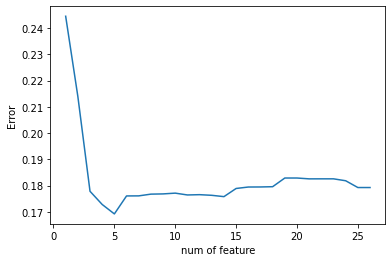

In [ ]:
plt.plot(np.arange(1, 27), errors)
plt.xlabel("num of feature")
plt.ylabel("Error")

## PCA - giảm chiều dữ liệu hay tìm quy luật ẩn
- PCA không giúp cải thiện hiệu suất của mô hình

In [ ]:
from sklearn.decomposition import PCA

for i in range(1, 6):
  pca = PCA(n_components=i)
  pca.fit(X_train)
  X_train_pca = pca.transform(X_train)
  X_test_pca = pca.transform(X_test)

  error = test_model(X_train_pca,X_test_pca, y_train, y_test)

  print(f"PCA {i} => error = {error}")

PCA 1 => error = 0.18476574425091696
PCA 2 => error = 0.17419372069730957
PCA 3 => error = 0.1735514880561154
PCA 4 => error = 0.17351214303393842
PCA 5 => error = 0.1691817803632315


## Lưu lại dữ liệu cho bước sau ...

In [ ]:
np.save("/content/drive/MyDrive/Colab Notebooks/KHDL-CK-19N13-Team3/feature_engineer/X_train.npy", X_train)
np.save("/content/drive/MyDrive/Colab Notebooks/KHDL-CK-19N13-Team3/feature_engineer/y_train.npy", y_train)
np.save("/content/drive/MyDrive/Colab Notebooks/KHDL-CK-19N13-Team3/feature_engineer/X_test.npy", X_test)
np.save("/content/drive/MyDrive/Colab Notebooks/KHDL-CK-19N13-Team3/feature_engineer/y_test.npy", y_test)

## 4. Mô hình hoá dữ liệu

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/KHDL-CK-19N13-Team3
!pwd

/content/drive/.shortcut-targets-by-id/12nABPUd5ifZSgY5ow8mJKGA2rwbBjbnG/KHDL-CK-19N13-Team3
/content/drive/.shortcut-targets-by-id/12nABPUd5ifZSgY5ow8mJKGA2rwbBjbnG/KHDL-CK-19N13-Team3


In [3]:
import numpy as np 
import pandas as pd
import itertools
!pip install colorama
from colorama import Fore

import seaborn as sns 
import matplotlib.pyplot as plt 

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR, LinearSVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import math
import warnings  
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###a. Datapipeline  
Datapipeline giúp thực hiện những tác vụ liên quan đến việc get dữ liệu, xử lý dữ liệu và phân chia dữ liệu. Trong phần này, datapipeline chỉ có chức năng lấy dữ liệu và phân chia thành các tập train & test vì phần xử lý đã được thực hiện ở các bước clean và feature engineering.

In [4]:
class DataPipeline:
    """
    Class DataPipepline
        Preprocessing data, including: reading, getting and splitting data for modeling tasks.
    ---------------------
    Properties:
        source: str
        Path of source containing raw data needed to process.
    ---------------------
    Methods:
        __init__(self, source: str):
        Initialize path to source data.
        
        read_data(self):
        Read .npy file from source to an np.array for modeling tasks.
        
        get_data(self, mode='train'):
        Get necessary features from raw data.
    """

    def __init__(self, source='/content/drive/MyDrive/KHDL-CK-19N13-Team3/feature_engineer'):
        self.source = source

    def read_data(self):
        self.X_train = np.load(self.source + "/X_train.npy")
        self.y_train = np.load(self.source + "/y_train.npy")
        self.X_test = np.load(self.source + "/X_test.npy")
        self.y_test = np.load(self.source + "/y_test.npy")

    def get_data(self, mode='train'):
        if mode == 'train':
            return self.X_train, self.y_train
        else:
            return self.X_test, self.y_test
        
    def __call__(self, mode='train'):
        self.read_data()
        return self.get_data(mode)

In [13]:
data_pipeline = DataPipeline()
X_train, y_train = data_pipeline('train')
X_test, y_test = data_pipeline('test')
print(X_train[:, 0].shape)
X_test[:, 0].shape

(636,)


(160,)

### b. Hồi quy tuyến tính (Linear Regression)
Hồi quy tuyến tính là một thuật toán học máy cơ bản thuộc loại học có giám sát. Đây là phương pháp thống kê để hồi quy dữ liệu với những biến phụ thuộc có giá trị liên tục dựa vào những biến độc lập (có thể liên tục hoặc không liên tục). 
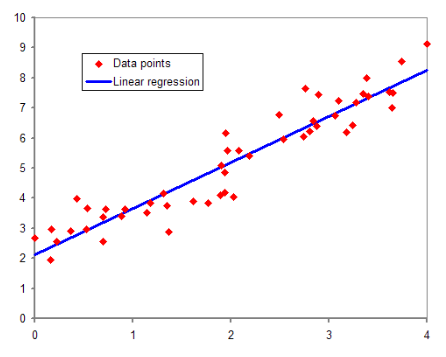

In [6]:
class ModelLinearRegression:
    """
    Class Model:
    Linear Regression's docs (using sklearn): https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
    ---------------------
    Properties:
        model: Linear Regression model.
        y_pred: list(float)
            Predicted values.
        score_mae: float 
            Mean absolute error score computed from y_pred and y_test (ground truth).
        score_rmse: float
            Root mean square error score computed from y_pred and y_test (ground truth).
        score_mape: float
            Mean absolute percentage error score computed from y_pred and y_test (ground truth).
    ---------------------
    Methods:
        __init__(self):
            Initialize the linear regression model.
        
        train(self, X_train, y_train):
            Train the model using train dataset.
        
        predict(self, X_test):
            Predict the values using data in X_test.
        
        evaluate(self, y_true, y_pred):
            Evaluate the predict result by computing 3 metrics scores (MAE, RMSE, MAPE)
        
        plot_result(self, width, height, X_test, y_test):
            Visualize the result including predict values (blue), ground truth (yellow).
            
        plot_yy(self, width, height, x_test, y_test):
            Visualize the predicted values & ground truth.
    """
    def __init__(self):
        self.model = LinearRegression()
    
    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)
        
    def predict(self, X_test):
        self.y_pred = self.model.predict(X_test)
        return self.y_pred
    
    def evaluate(self, y_true, y_pred):
        self.score_mae = mean_absolute_error(y_true, y_pred)
        self.score_rmse = math.sqrt(mean_squared_error(y_true, y_pred))
        self.score_mape = mean_absolute_percentage_error(y_true, y_pred)
        
        print(Fore.GREEN + 'MAE: {}'.format(self.score_mae))
        print(Fore.GREEN + 'RMSE: {}'.format(self.score_rmse))
        print(Fore.GREEN + 'MAPE: {}'.format(self.score_mape))
        
        return self.score_mae, self.score_rmse, self.score_mape
    
    def plot_result(self, width, height, X_test, y_test):
        f, ax = plt.subplots(1)
        f.set_figheight(height)
        f.set_figwidth(width)

        sns.lineplot(x=range(0, X_test[:, 0].shape[0]), y=self.y_pred, ax=ax, color='blue', label='Predict')
        sns.lineplot(x=range(0, X_test[:, 0].shape[0]), y=y_test, ax=ax, color='orange', label='Ground truth') 

        ax.set_title(f'Prediction \n MAE: {self.score_mae:.2f}, RMSE: {self.score_rmse:.2f}, MAPE: {self.score_mape:.2f}', fontsize=14)
        ax.set_xlabel(xlabel='Sample', fontsize=14)
        ax.set_ylabel(ylabel='Price', fontsize=14)
        plt.show()

    def plot_yy(self, width, height, y_pred, y_test):
        f, ax = plt.subplots(1)
        f.set_figheight(height)
        f.set_figwidth(width)
        plt.scatter(y_test, y_pred, color='red')
        plt.plot(y_test, y_test)
        plt.grid()
        plt.xlabel('Actual price')
        plt.ylabel('Predicted price')
        plt.title('Scatter plot between actual y and predicted y')
        plt.show()

MAE: 3676693.138200755
RMSE: 5750183.47422443
MAPE: 0.16918178036323153


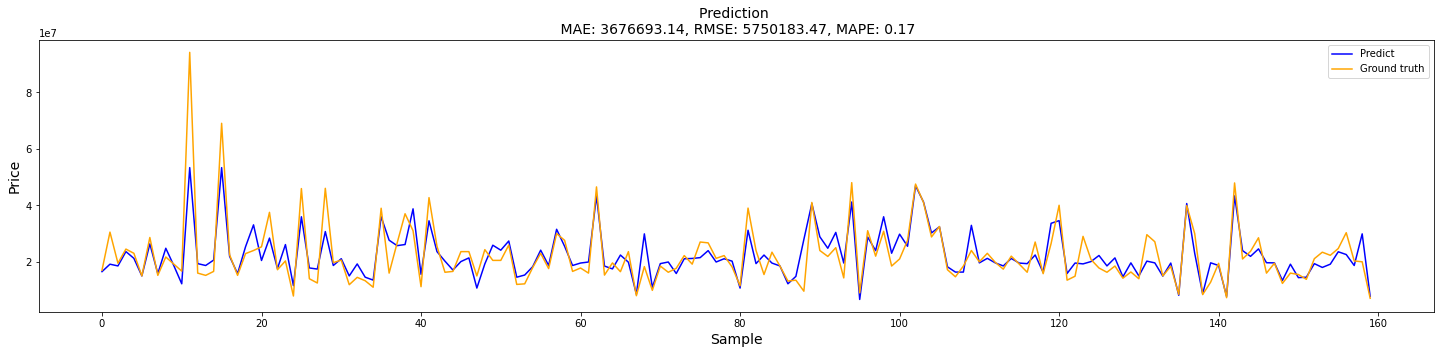

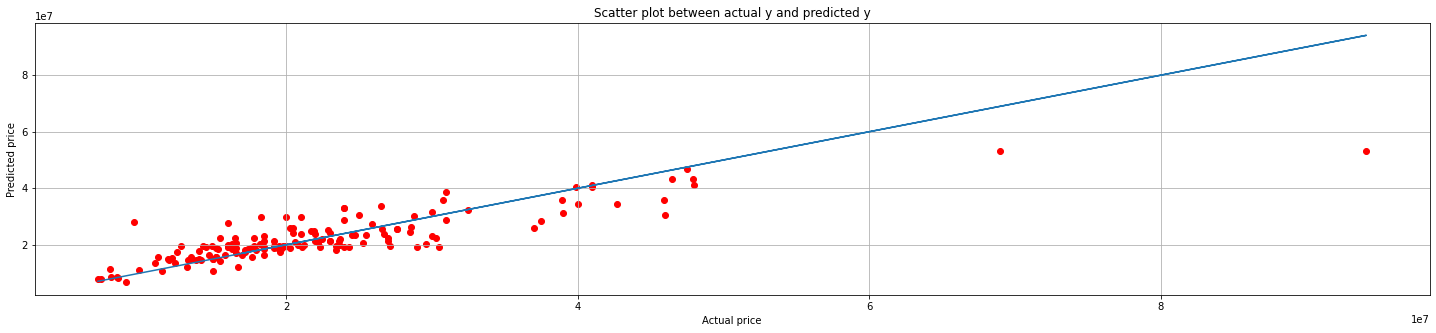

In [7]:
linear_reg = ModelLinearRegression()
linear_reg.train(X_train, y_train)
linear_y_pred = linear_reg.predict(X_test)
linear_score_mae, linear_score_rmse, linear_score_mape = linear_reg.evaluate(y_test, linear_y_pred)
linear_reg.plot_result(25, 5, X_test, y_test)
linear_reg.plot_yy(25, 5, linear_y_pred, y_test)

###c. Hồi quy SGD (SGD Regressor)  
Hồi quy SGD cũng là một mô hình hồi quy tuyến tính nhưng tối ưu loss bằng thuật toán Stochastic Gradient Descent (SGD).  Nói về SGD thì đây là thuật toán chọn ngẫu nhiên 1 vài điểm dữ liệu trên toàn bộ dữ liệu (thường gọi là 1 batch) và tiến hành tính toán loss, cập nhật w cho một lần lặp. SGD mặc dù đường hồi quy đến cực tiểu biến thiên gồ ghề hơn và số lần lặp lớn hơn nhưng lại giúp tiết kiệm chi phí về mặt tính toán và thời gian đáng kể so với GD (gradient descent nguyên thủy). Trong thực tế, người ta ưu tiên dùng SGD hơn GD. 

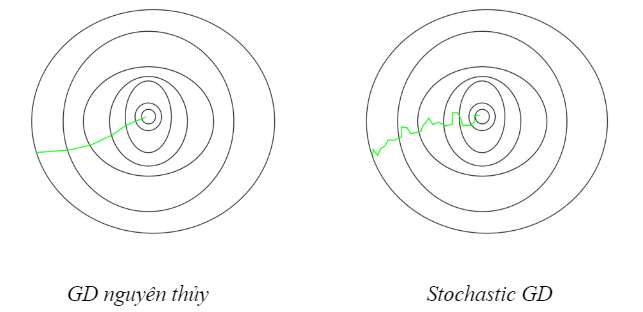

In [ ]:
class ModelSGDRegressor:
    """
    Class Model:
    Stochastic Gradient Descent Regressor's docs (using sklearn): https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html
    ---------------------
    Properties:
        model: Stochastic Gradient Descent Regressor model.
        y_pred: list(float)
            Predicted values.
        score_mae: float 
            Mean absolute error score computed from y_pred and y_test (ground truth).
        score_rmse: float
            Root mean square error score computed from y_pred and y_test (ground truth).
        score_mape: float
            Mean absolute percentage error score computed from y_pred and y_test (ground truth).
    ---------------------
    Methods:
        __init__(self):
            Initialize the SVR model.

        find_best(self):
            Define lists of hyperparameters and choose the best params set using GridSearchCV.
        
        train(self, X_train, y_train):
            Train the model using train dataset.
        
        predict(self, X_test):
            Predict the values using data in X_test.
        
        evaluate(self, y_true, y_pred) -> tuple(float):
            Evaluate the predict result by computing 3 metrics scores (MAE, RMSE, MAPE)
        
        plot_result(self, width, height, X_test, y_test):
            Visualize the result including predict values (blue), ground truth (yellow).
            
        plot_yy(self, width, height, x_test, y_test):
            Visualize the predicted values & ground truth.
    """
    def __init__(self):
        self.model = SGDRegressor()

    def find_best(self):
        param_grid = {
            'alpha': 10.0 ** -np.arange(0, 7),
            'loss': ['huber', 'epsilon_insensitive', 'squared_error'],
            'penalty': ['l2', 'l1', 'elasticnet'],
            'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
            'early_stopping': [True, False],
            'eta0': 10.0 ** -np.arange(0, 7)
        }
        self.model = GridSearchCV(self.model, param_grid)
    
    def train(self, X_train, y_train):
        self.find_best()
        self.model.fit(X_train, y_train)
        print(self.model.best_params_)
        
    def predict(self, X_test):
        self.y_pred = self.model.predict(X_test)
        return self.y_pred
    
    def evaluate(self, y_true, y_pred):
        self.score_mae = mean_absolute_error(y_true, y_pred)
        self.score_rmse = math.sqrt(mean_squared_error(y_true, y_pred))
        self.score_mape = mean_absolute_percentage_error(y_true, y_pred)
        
        print(Fore.GREEN + 'MAE: {}'.format(self.score_mae))
        print(Fore.GREEN + 'RMSE: {}'.format(self.score_rmse))
        print(Fore.GREEN + 'MAPE: {}'.format(self.score_mape))
        
        return self.score_mae, self.score_rmse, self.score_mape
    
    def plot_result(self, width, height, X_test, y_test):
        f, ax = plt.subplots(1)
        f.set_figheight(height)
        f.set_figwidth(width)

        sns.lineplot(x=range(0, X_test[:, 0].shape[0]), y=self.y_pred, ax=ax, color='blue', label='Predict')
        sns.lineplot(x=range(0, X_test[:, 0].shape[0]), y=y_test, ax=ax, color='orange', label='Ground truth') 

        ax.set_title(f'Prediction \n MAE: {self.score_mae:.2f}, RMSE: {self.score_rmse:.2f}, MAPE: {self.score_mape:.2f}', fontsize=14)
        ax.set_xlabel(xlabel='Sample', fontsize=14)
        ax.set_ylabel(ylabel='Price', fontsize=14)
        plt.show()

    def plot_yy(self, width, height, y_pred, y_test):
        f, ax = plt.subplots(1)
        f.set_figheight(height)
        f.set_figwidth(width)
        plt.scatter(y_test, y_pred, color='red')
        plt.plot(y_test, y_test)
        plt.grid()
        plt.xlabel('Actual price')
        plt.ylabel('Predicted price')
        plt.title('Scatter plot between actual y and predicted y')
        plt.show()

{'alpha': 0.001, 'early_stopping': True, 'eta0': 0.001, 'learning_rate': 'adaptive', 'loss': 'squared_error', 'penalty': 'l2'}
MAE: 3664400.6159835444
RMSE: 5760659.51959004
MAPE: 0.16823288435326564


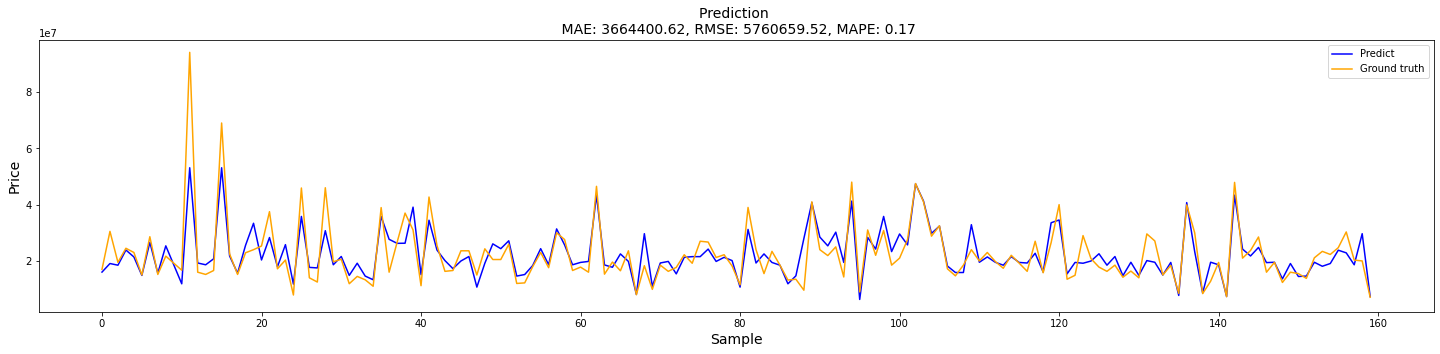

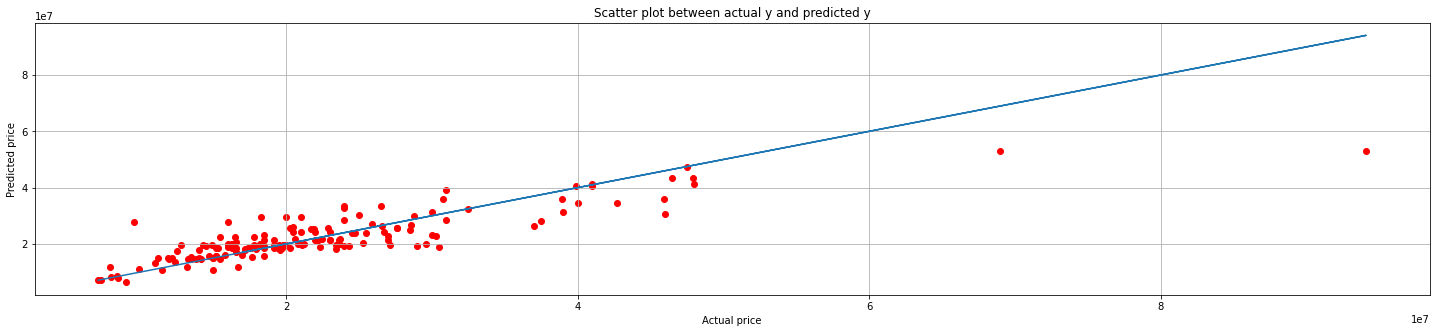

In [ ]:
sgd_reg = ModelSGDRegressor()
sgd_reg.train(X_train, y_train)
sgd_y_pred = sgd_reg.predict(X_test)
sgd_score_mae, sgd_score_rmse, sgd_score_mape = sgd_reg.evaluate(y_test, sgd_y_pred)
sgd_reg.plot_result(25, 5, X_test, y_test)
sgd_reg.plot_yy(25, 5, sgd_y_pred, y_test)

###d. Support Vector Regression (SVR)  
Support Vector Machine thường được biết đến là được sử dụng cho bài toán phân loại (classify) và hiếm khi được sử dụng trong bài toán hồi quy. Bởi vì mục tiêu của Support Vector là đi tìm một siêu phẳng trong không gian n chiều sao cho margin giữa các điểm dữ liệu trong từng lớp là lớn nhất.

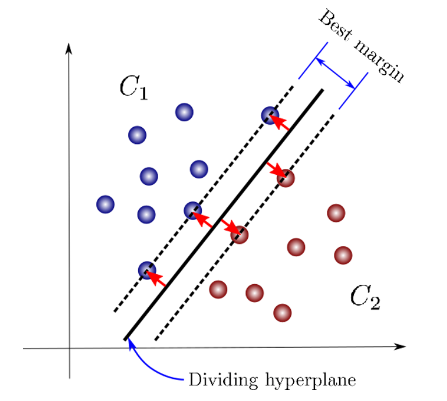

Tuy nhiên, khi hầu hết các điểm dữ liệu chủ yếu nằm trong biên độ (margin) tốt nhất về mỗi phía của siêu phẳng thì SVR hay còn gọi là hồi quy vector hỗ trợ có thể được sử dụng để xác định và dự đoán dữ liệu phụ thuộc (y).


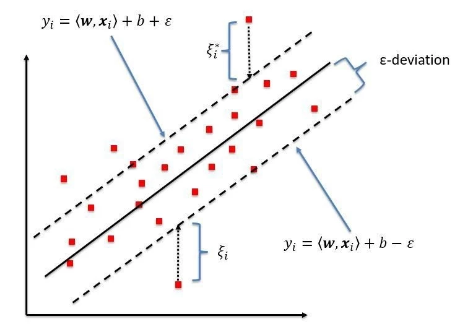

In [ ]:
class ModelSVR:
    """
    Class Model:
    Support Vector Regression's docs (using sklearn): https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
    ---------------------
    Properties:
        model: Support Vector Regression model.
        y_pred: list(float)
            Predicted values.
        score_mae: float 
            Mean absolute error score computed from y_pred and y_test (ground truth).
        score_rmse: float
            Root mean square error score computed from y_pred and y_test (ground truth).
        score_mape: float
            Mean absolute percentage error score computed from y_pred and y_test (ground truth).
    ---------------------
    Methods:
        __init__(self):
            Initialize the SVR model.
        
        train(self, X_train, y_train):
            Train the model using train dataset.
        
        predict(self, X_test):
            Predict the values using data in X_test.
        
        evaluate(self, y_true, y_pred) -> tuple(float):
            Evaluate the predict result by computing 3 metrics scores (MAE, RMSE, MAPE)
        
        plot_result(self, width, height, X_test, y_test):
            Visualize the result including predict values (blue), ground truth (yellow).
            
        plot_yy(self, width, height, x_test, y_test):
            Visualize the predicted values & ground truth.
    """
    def __init__(self):
        self.model = SVR()
    
    def train(self, X_train, y_train):
        svrgs_parameters = {
            'kernel': ['linear', 'poly', 'rbf'],
            'C':     [100000, 150000, 1000000, 1500000, 5000000, 10000000, 50000000],
            'gamma': [10e-10, 10e-9, 10e-8, 10e-7, 0.000001, 0.00001, 0.0001],
        }

        self.model = GridSearchCV(SVR(), svrgs_parameters, scoring='neg_mean_squared_error')
        self.model.fit(X_train, y_train)
        print("SVR GridSearch score: " + str(self.model.best_score_))
        print("SVR GridSearch params: ")
        print(self.model.best_params_)
                
    def predict(self, X_test):
        self.y_pred = self.model.best_estimator_.predict(X_test)
        return self.y_pred
    
    def evaluate(self, y_true, y_pred):
        self.score_mae = mean_absolute_error(y_true, y_pred)
        self.score_rmse = math.sqrt(mean_squared_error(y_true, y_pred))
        self.score_mape = mean_absolute_percentage_error(y_true, y_pred)
        
        print(Fore.GREEN + 'MAE: {}'.format(self.score_mae))
        print(Fore.GREEN + 'RMSE: {}'.format(self.score_rmse))
        print(Fore.GREEN + 'MAPE: {}'.format(self.score_mape))
        
        return self.score_mae, self.score_rmse, self.score_mape
    
    def plot_result(self, width, height, X_test, y_test):
        f, ax = plt.subplots(1)
        f.set_figheight(height)
        f.set_figwidth(width)

        sns.lineplot(x=range(0, X_test[:, 0].shape[0]), y=self.y_pred, ax=ax, color='blue', label='Predict')
        sns.lineplot(x=range(0, X_test[:, 0].shape[0]), y=y_test, ax=ax, color='orange', label='Ground truth') 

        ax.set_title(f'Prediction \n MAE: {self.score_mae:.2f}, RMSE: {self.score_rmse:.2f}, MAPE: {self.score_mape:.2f}', fontsize=14)
        ax.set_xlabel(xlabel='Sample', fontsize=14)
        ax.set_ylabel(ylabel='Price', fontsize=14)
        plt.show()

    def plot_yy(self, width, height, y_pred, y_test):
        f, ax = plt.subplots(1)
        f.set_figheight(height)
        f.set_figwidth(width)
        plt.scatter(y_test, y_pred, color='red')
        plt.plot(y_test, y_test)
        plt.grid()
        plt.xlabel('Actual price')
        plt.ylabel('Predicted price')
        plt.title('Scatter plot between actual y and predicted y')
        plt.show()

SVR GridSearch score: -30044007009980.51
SVR GridSearch params: 
{'C': 50000000, 'gamma': 1e-09, 'kernel': 'linear'}
MAE: 3836862.6197154685
RMSE: 6095514.099684361
MAPE: 0.16840441392193015


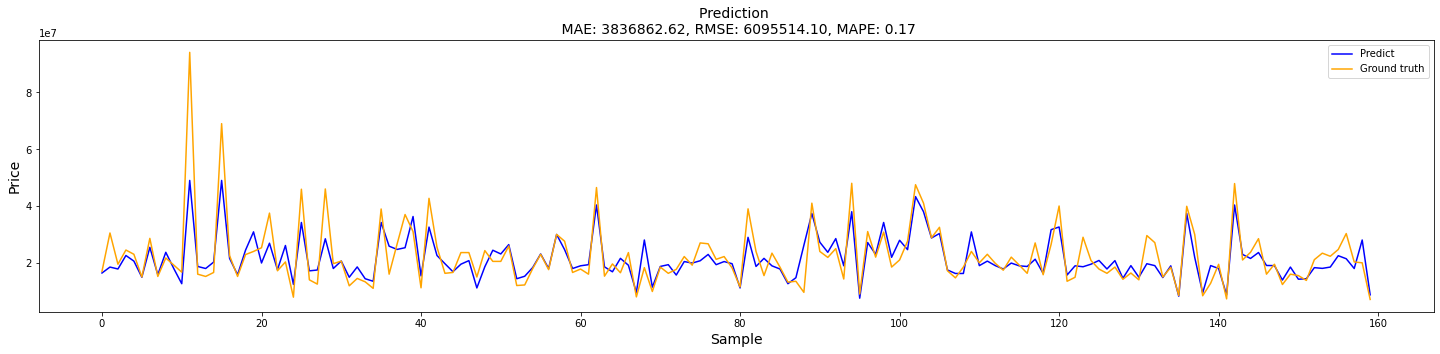

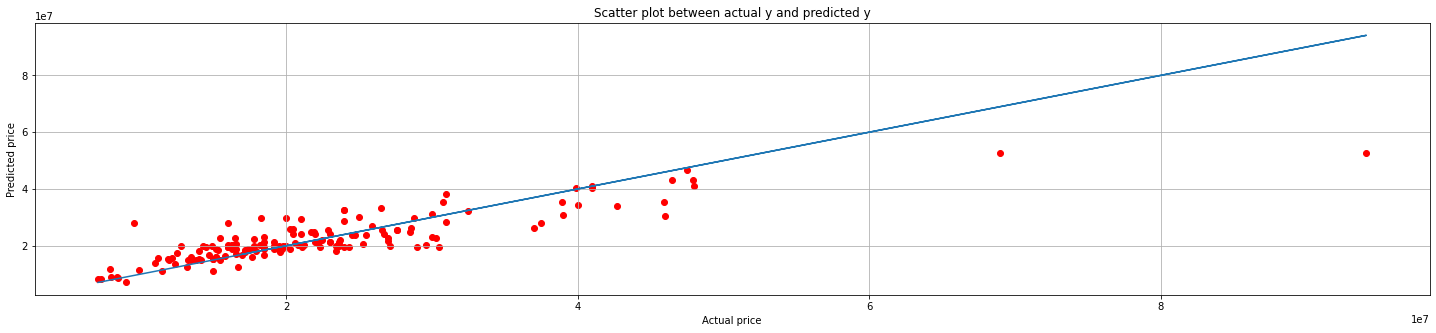

In [ ]:
svr_reg = ModelSVR()
svr_reg.train(X_train, y_train)
svr_y_pred = svr_reg.predict(X_test)
svr_score_mae, svr_score_rmse, svr_score_mape = svr_reg.evaluate(y_test, svr_y_pred)
svr_reg.plot_result(25, 5, X_test, y_test)
svr_reg.plot_yy(25, 5, sgd_y_pred, y_test)

## 5. Kết luận

###a. Kết quả chung cho 3 mô hình

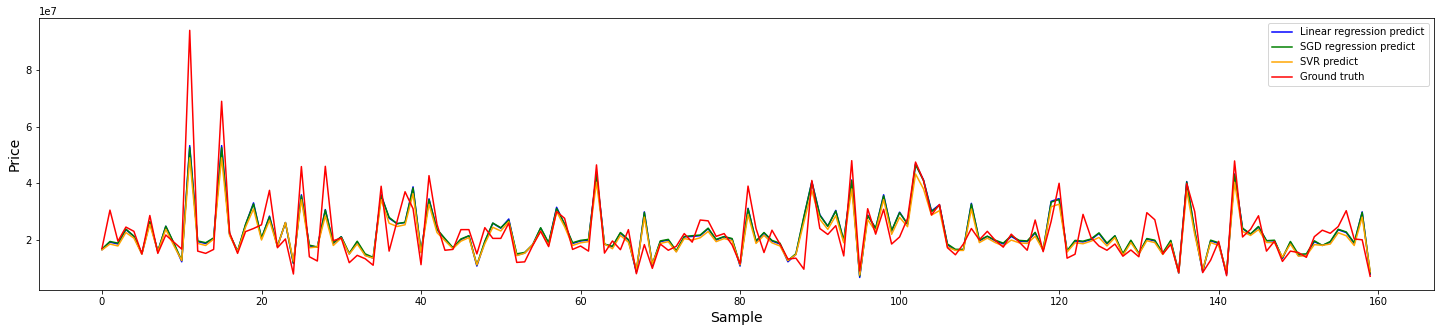

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(25)

sns.lineplot(x=range(0, X_test[:, 0].shape[0]), y=linear_y_pred, ax=ax, color='blue', label='Linear regression predict')
sns.lineplot(x=range(0, X_test[:, 0].shape[0]), y=sgd_y_pred, ax=ax, color='green', label='SGD regression predict')
sns.lineplot(x=range(0, X_test[:, 0].shape[0]), y=svr_y_pred, ax=ax, color='orange', label='SVR predict')
sns.lineplot(x=range(0, X_test[:, 0].shape[0]), y=y_test, ax=ax, color='red', label='Ground truth') 

ax.set_xlabel(xlabel='Sample', fontsize=14)
ax.set_ylabel(ylabel='Price', fontsize=14)
plt.show()

###b. Metrics trên 3 mô hình
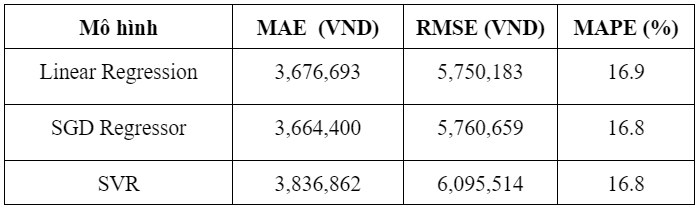


###c. Giải thích, dự đoán nguyên nhân

- Kích thước dữ liệu nhỏ (~800 mẫu).  
- Mất cân bằng dữ liệu, phần lớn dữ liệu tập trung ở tầm giá thấp và vừa nên mô hình sẽ không học được những mẫu có giá ở tầm cao hơn.


###d. Hướng phát triển 

- Mặc dù dữ liệu thu thập có nhiều thuộc tính nhưng chưa khai thác hết các thuộc tính đó, sau bước lựa chọn thuộc tính thì loại bỏ rất nhiều thuộc tính, đặc biệt là thuộc tính thuộc loại category. Vì vậy cần lựa chọn phương thức mã hóa thích hợp để khai thác các thuộc tính này.  
- Thu thập thêm dữ liệu, làm đa dạng dữ liệu.  
- Thử nghiệm down sample (đối với những mẫu chiếm tỉ lệ lớn trong tập dữ liệu) hoặc up sample (đối với những mẫu dữ liệu chiếm tỉ lệ thấp trong tập dữ liệu) để giúp cân bằng dữ liệu.
- Sử dụng một số mô hình hồi quy khác: Random Forest Regressor, XGBoost,...


MAE: 3248187.29421985
RMSE: 5265537.302109873
MAPE: 0.1529004180101674


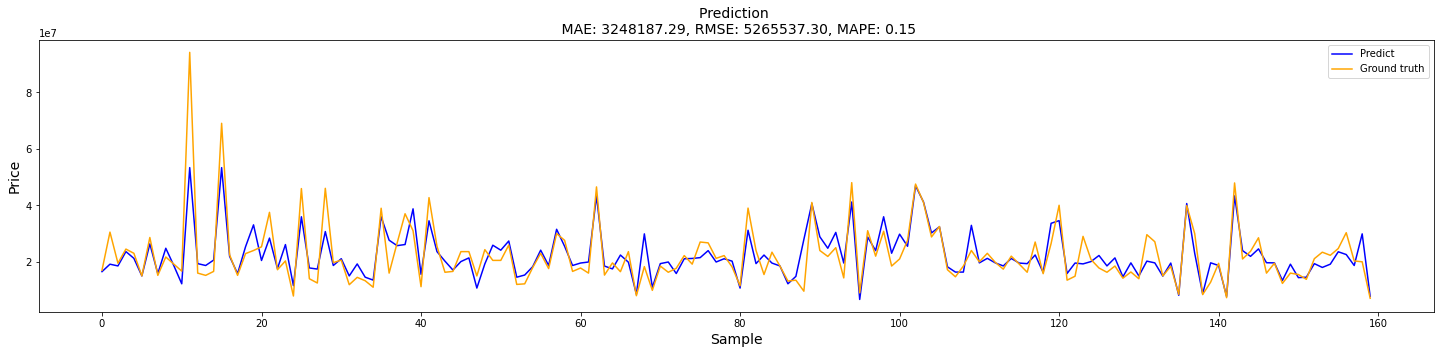

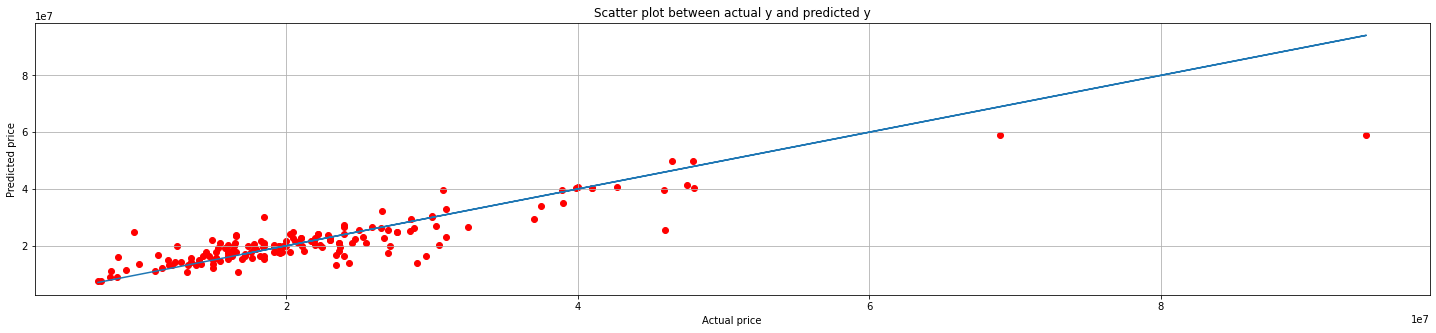

In [12]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(random_state=42)
regr.fit(X_train, y_train)
rf_y_pred = regr.predict(X_test)
rf_score_mae, rf_score_rmse, rf_score_mape = linear_reg.evaluate(y_test, rf_y_pred)
linear_reg.plot_result(25, 5, X_test, y_test)
linear_reg.plot_yy(25, 5, rf_y_pred, y_test)